# Clasificación de Enfermedades Pulmonares con Deep Learning

Este trabajo aplica **Redes Neuronales Convolucionales CNN**, **CNN-LSTM y CNN-BLSTM** para la detección automática de enfermedades pulmonares asma, EPOC, neumonía, y la condición normal a partir de sonidos respiratorios.  
Se trabajó con coeficientes **MFCC** extraídos de audios clínicos, alcanzando métricas superiores al **80% de exactitud**.

##Librerias

In [ ]:
#Librerías de operar datos
import numpy as np
import matplotlib.pyplot as plt

#Librerias de MFCC
import librosa
import librosa.display

import os
import glob
import sklearn

#separacion en train,test y validacion
from sklearn.model_selection import train_test_split

#para red neuronal
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

#regularización
from keras import regularizers

#optimizador
from tensorflow.keras.optimizers import Adam

#Cargar modelo
from tensorflow.keras.models import load_model

#Convolucional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#Early
from tensorflow.keras.callbacks import EarlyStopping




## 1. Preprocesamiento de datos

- **Entrada**: audios de respiración convertidos a coeficientes MFCC.  
- **Forma de los datos**: `(n_samples, 13, 130, 1)`  
- **Etapas**: filtrado de calidad, segmentación con y sin solapamiento, balanceo, extracción de coeficientes MFCC y normalización.  

In [ ]:
# ========================
# 📊 Mostrar fragmentos por clase (después del balanceo)
# ========================
print("\n📊 Fragmentos por clase después del balanceo:")
conteo_final = Counter(y_bal)
for i, clase in enumerate(clases):
    print(f"  {clase}: {conteo_final[i]} fragmentos")


📊 Fragmentos por clase después del balanceo:
  Asma: 421 fragmentos
  Epoc: 421 fragmentos
  Neumonia: 421 fragmentos
  Normal: 421 fragmentos


In [ ]:
# ========================
# 📌 División en conjuntos de entrenamiento, validación y prueba
#     sin mezclar fragmentos del mismo archivo
# ========================
#Evitar que fragmentos del mismo audio original terminen en distintos conjuntos (entrenamiento, validación, prueba),
#ya que eso puede inflar artificialmente el rendimiento del modelo.
print("\n📦 Dividiendo en train/val/test sin mezcla de archivos...")

# Primera división: 70% entrenamiento, 30% temporal
#GroupShuffleSplit divide los datos asegurando que fragmentos con el mismo file_id queden juntos.
#train_size=0.7 → 70% para entrenamiento. Lo que queda (30%) se llama temp_idx y se usará para validación y prueba.
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, temp_idx = next(gss.split(X_bal, y_bal, groups=file_ids_bal))

# Segunda división: temporal en 15% validación, 15% prueba
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx, test_idx = next(gss2.split(X_bal[temp_idx], y_bal[temp_idx], groups=np.array(file_ids_bal)[temp_idx]))

# Crear los conjuntos finales
#Se generan los arrays finales de entrada(X_train, X_val, X_test) y etiquetas (y_train , y_val, y_test)
X_train = X_bal[train_idx]
y_train = y_bal[train_idx]
X_val = X_bal[temp_idx][val_idx]
y_val = y_bal[temp_idx][val_idx]
X_test = X_bal[temp_idx][test_idx]
y_test = y_bal[temp_idx][test_idx]

print(f"✅ Train: {len(X_train)} fragmentos")
print(f"✅ Val:   {len(X_val)} fragmentos")
print(f"✅ Test:  {len(X_test)} fragmentos")

# ========================
# 📌 One-hot encoding de las etiquetas y reshape para CNN
# ========================
print("\n🔄 Aplicando one-hot encoding y reshape...")

# Codificar las etiquetas
#Convierte las etiquetas numéricas (0, 1, ...) en vectores binarios:
#Por ejemplo, si hay 2 clases:0 → [1, 0],1 → [0, 1]
y_train = to_categorical(y_train, num_classes=len(clases))
y_val = to_categorical(y_val, num_classes=len(clases))
y_test = to_categorical(y_test, num_classes=len(clases))

# Redimensionar para input a una CNN (altura, ancho, canales)
#transforma cada matriz MFCC a una forma compatible con las capas convolucionales 2D, típicamente:
#Altura = 13 (número de coeficientes MFCC), Ancho = número de frames (por ejemplo, 130),
#Canal = 1 (porque es un "pseudoimagen" en escala de grises)
X_train = X_train.reshape(-1, 13, X_train.shape[2], 1)
X_val = X_val.reshape(-1, 13, X_val.shape[2], 1)
X_test = X_test.reshape(-1, 13, X_test.shape[2], 1)

print("✅ Datos listos para entrenamiento.")



📦 Dividiendo en train/val/test sin mezcla de archivos...
✅ Train: 1145 fragmentos
✅ Val:   276 fragmentos
✅ Test:  263 fragmentos

🔄 Aplicando one-hot encoding y reshape...
✅ Datos listos para entrenamiento.


## 2. Entrenamiento del modelo CNN-LSTM



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Reshape, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential()

# 🔹 CNN Block 1
model.add(Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.003), input_shape=(13, 130, 1)))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# 🔹 CNN Block 2
model.add(Conv2D(256, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.003)))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# 🔹 CNN Block 3
model.add(Conv2D(512, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.003)))
model.add(MaxPooling2D(pool_size=(2,1)))
model.add(BatchNormalization())
model.add(Dropout(0.15))

# 🔹 Reshape para LSTM
model.add(Reshape((model.output_shape[1] * model.output_shape[2], model.output_shape[3])))

# 🔹 LSTM (sin bidireccionalidad)
model.add(LSTM(128, return_sequences=True, dropout=0.35))
model.add(LSTM(64, return_sequences=True, dropout=0.35))

# 🔹 Pooling global
model.add(GlobalAveragePooling1D())

# 🔹 Capas densas
model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

# 🔹 Compilación
optimizer = Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 🔹 Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# 🔹 Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=250,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.3008 - loss: 2.9178 - val_accuracy: 0.2971 - val_loss: 2.9146 - learning_rate: 2.0000e-05
Epoch 2/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4097 - loss: 2.8459 - val_accuracy: 0.2971 - val_loss: 2.8973 - learning_rate: 2.0000e-05
Epoch 3/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4573 - loss: 2.7793 - val_accuracy: 0.2971 - val_loss: 2.8831 - learning_rate: 2.0000e-05
Epoch 4/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.4539 - loss: 2.7349 - val_accuracy: 0.2971 - val_loss: 2.8603 - learning_rate: 2.0000e-05
Epoch 5/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5019 - loss: 2.6914 - val_accuracy: 0.2971 - val_loss: 2.8350 - learning_rate: 2.0000e-05
Epoch 6/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5562 - loss: 2.6359 - val_accuracy: 0.3623 - val_loss: 2.7942 - learning_rate: 2.0000e-05
Epoch 7/250
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 

## 3. Resultados

Se evaluaron: accuracy, precisión, sencibilidad, F1 y AUC en la curva ROC.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1️⃣ Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir predicciones a etiquetas
y_test_classes = np.argmax(y_test, axis=1)  # Convertir etiquetas one-hot a índices

# 2️⃣ Calcular la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusión:")
print(cm)

# 3️⃣ Calcular F1-score, Precisión y Recall,Support
print("\nReporte de Clasificación:")
print(classification_report(y_test_classes, y_pred_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Matriz de Confusión:
[[47  0  9  9]
 [ 0 69  1  1]
 [ 2  6 55  9]
 [ 8  3  3 41]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        65
           1       0.88      0.97      0.93        71
           2       0.81      0.76      0.79        72
           3       0.68      0.75      0.71        55

    accuracy                           0.81       263
   macro avg       0.80      0.80      0.80       263
weighted avg       0.81      0.81      0.80       263



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


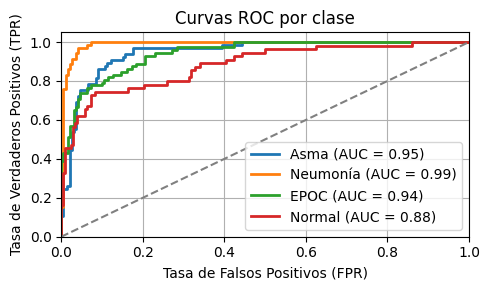

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Establecer fuente global
plt.rcParams['font.family'] = 'DejaVu Sans'

# Suponiendo 4 clases
num_classes = 4
class_names = ['Asma', 'Neumonía', 'EPOC', 'Normal']

# 📌 Predecir probabilidades en el conjunto de prueba
y_pred_probs = model.predict(X_test)

# 📌 Asegurar que y_test esté binarizado (one-hot)
# y_test = label_binarize(y_test, classes=[0, 1, 2, 3])  # si necesario

# Inicializar figura
plt.figure(figsize=(5, 3))

# 📌 Calcular curva ROC y AUC para cada clase
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Configurar gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Conclusión

*  Se clasificaron con éxito los sonidos respiratorios en cuatro clases: asma, EPOC, neumonía y condición normal.

*  Se alcanzó una exactitud superior al 80%, lo que evidencia el potencial del Deep Learning en aplicaciones de Bioingeniería.
*  Como trabajo futuro, se propone ampliar el dataset para mejorar la robustez y generalización de los modelos.




